In [1]:
!pip install wfdb

     |████████████████████████████████| 137 kB 5.2 MB/s 


In [14]:
import wfdb
import pywt

import os
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import pickle

In [3]:
wfdb.dl_database('mitdb', dl_dir = 'mit_bih')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [4]:
input_dir = 'mit_bih/*.atr'
ecg_data = sorted([os.path.splitext(i)[0] for i in glob(input_dir)])

In [5]:
classes = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
sub = {'N':'N', 'L':'N', 'R':'N', 'e':'N', 'j':'N', 
        'A':'S', 'a':'S', 'J':'S', 'S':'S',
        'V':'V', 'E':'V',
        'F':'F',
        '/':'Q', 'f':'Q', 'Q':'Q'}

In [6]:
def  denoise (data):
    # Wavelet transform
    coeffs = pywt.wavedec(data, 'db8', level = 9)
    cA9, cD9,cD8, cD7, cD6, cD5, cD4,cD3, cD2, cD1 = coeffs
    
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(data))))

    for  i  in  range ( 1 , len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    return pywt.waverec(coeffs, 'db8')


In [7]:
def hb_segmentation(ecg, _denoise= False):
    signals = []
    labels = []

    record = wfdb.rdrecord(ecg)
    ann = wfdb.rdann(ecg, extension = 'atr')

    for sig_name, signal in zip(record.sig_name, record.p_signal.T):
        
        if sig_name == 'MLII':
            signal = scale(signal)
            
            for i, (label, R) in enumerate(zip(ann.symbol, ann.sample)):

                if label in sub.keys():
                    enc_label = sub[label]
                    enc_label = classes[enc_label]
                    l, r = R - 90, R + 190

                    if np.all([l > 0, r < len(signal)]):
                        f = signal[l: r].tolist()

                        if _denoise:
                            #f, cD3, cD2, cD1 = pywt.wavedec(f, 'db4', level = 3)
                            f = denoise(f)
                        labels.append(enc_label)
                        signals.append(f)

    return (signals, labels)

In [8]:
X = []
y = []

for i in ecg_data:
    a, b = hb_segmentation(i, True)
    X.extend(a)
    y.extend(b)
del a, b
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python3.7/

In [9]:
X.shape, y.shape

((105038, 280), (105038,))

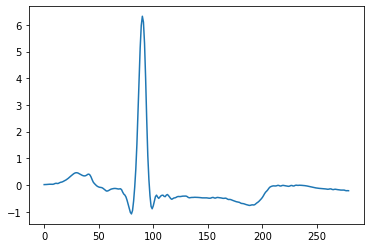

In [10]:
plt.plot(X[0])

In [11]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3)

In [ ]:
clas = SVC()

In [ ]:
clas.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = clas.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9802297537446052

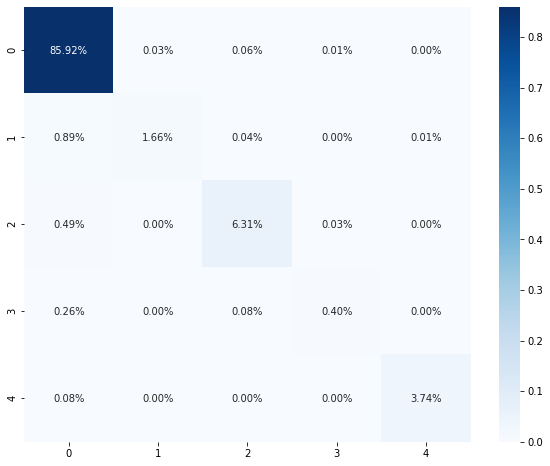

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(confusion_matrix(y_test, y_pred) / np.sum(confusion_matrix(y_test, y_pred)), cmap = 'Blues', annot = True, fmt = '.2%' )

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27107
           1       0.98      0.64      0.77       820
           2       0.97      0.92      0.95      2152
           3       0.91      0.54      0.68       231
           4       1.00      0.98      0.99      1202

    accuracy                           0.98     31512
   macro avg       0.97      0.82      0.88     31512
weighted avg       0.98      0.98      0.98     31512



In [ ]:
unique, counts = np.unique(y_train, return_counts = True)
print(unique, counts)

[0 1 2 3 4] [63224  1961  5077   571  2693]


In [ ]:
# class_weight = {0: 1,
#                 1: 70,
#                 2: 30,
#                 3: 100,
#                 4: 50}

In [ ]:
clas2 = RandomForestClassifier()
clas2.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred2 = clas2.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred2)

0.9804201574003554

In [ ]:
confusion_matrix(y_test, y_pred2)

array([[27068,    27,    25,     2,     4],
       [  267,   565,     4,     0,     0],
       [  130,     0,  2008,     7,     2],
       [   98,     0,    20,   110,     0],
       [   30,     0,     1,     0,  1144]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27126
           1       0.95      0.68      0.79       836
           2       0.98      0.94      0.96      2147
           3       0.92      0.48      0.63       228
           4       0.99      0.97      0.98      1175

    accuracy                           0.98     31512
   macro avg       0.97      0.81      0.87     31512
weighted avg       0.98      0.98      0.98     31512



<h2><b>Trying Over Sampling

In [12]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek()

X_train_re_smap, y_train_re_samp = smt.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [13]:
unique, counts = np.unique(y_train_re_samp, return_counts = True)
print(unique, counts)

[0 1 2 3 4] [63161 63163 63161 63163 63163]


<h1><b> Random Forset


In [ ]:
clas3 = RandomForestClassifier()
clas3.fit(X_train_re_smap, y_train_re_samp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred2 = clas3.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred2)

0.986005331302361

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27107
           1       0.90      0.83      0.86       820
           2       0.97      0.95      0.96      2152
           3       0.83      0.78      0.80       231
           4       1.00      0.99      0.99      1202

    accuracy                           0.99     31512
   macro avg       0.94      0.91      0.92     31512
weighted avg       0.99      0.99      0.99     31512



In [ ]:
confusion_matrix(y_test, y_pred2)

array([[26973,    72,    39,    21,     2],
       [  137,   678,     3,     1,     1],
       [   90,     0,  2046,    15,     1],
       [   35,     0,    16,   180,     0],
       [    8,     0,     0,     0,  1194]])

In [44]:
from sklearn.model_selection import cross_val_score
a = cross_val_score(estimator = clas3, X = X_train_re_smap, y = y_train_re_samp, cv = 5)

In [46]:
a.mean()*100

99.73781784399753

In [52]:
a

array([0.99746687, 0.99754599, 0.9974035 , 0.99713435, 0.99734017])

In [55]:
pickle.dump(clas3, open('model.sav', 'wb'))

<h1><b>Trying With ADABoost

In [15]:
clas4 = AdaBoostClassifier()
clas4.fit(X_train_re_smap, y_train_re_samp)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [16]:
ypred3 = clas4.predict(X_test)

In [18]:
accuracy_score(y_test, ypred3)

0.5778433612592029

In [21]:
print(classification_report(y_test, ypred3))

              precision    recall  f1-score   support

           0       0.96      0.55      0.70     27168
           1       0.06      0.52      0.11       821
           2       0.49      0.80      0.61      2135
           3       0.04      0.74      0.08       222
           4       0.72      0.93      0.81      1166

    accuracy                           0.58     31512
   macro avg       0.45      0.71      0.46     31512
weighted avg       0.89      0.58      0.68     31512



<h1><b>Gradient Boosting

In [47]:
from xgboost import XGBClassifier

In [48]:
clas_gbm = XGBClassifier(max_depth = 4)
clas_gbm.fit(X_train_re_smap, y_train_re_samp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
ypred_gbm = clas_gbm.predict(X_test)

In [50]:
print(classification_report(y_test, ypred_gbm))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     27168
           1       0.40      0.81      0.53       821
           2       0.85      0.96      0.90      2135
           3       0.26      0.83      0.39       222
           4       0.97      0.99      0.98      1166

    accuracy                           0.93     31512
   macro avg       0.69      0.90      0.75     31512
weighted avg       0.96      0.93      0.94     31512



In [53]:
accuracy_score(y_test, ypred_gbm)

0.9311690784463061